<a href="https://colab.research.google.com/github/mart-anthony-stark/Machine-Learning-and-Deep-Learning/blob/main/Fake_News_Detection_PH.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import missingno

# Data Exploration

In [2]:
df = pd.read_csv('fakenews_data_ph.csv')

In [ ]:
df.head()

,label,article
0,0,"Ayon sa TheWrap.com, naghain ng kaso si Krupa,..."
1,0,Kilala rin ang singer sa pagkumpas ng kanyang ...
2,0,"BLANTYRE, Malawi (AP) -- Bumiyahe patungong Ma..."
3,0,"Kasama sa programa ang pananalangin, bulaklak ..."
4,0,Linisin ang Friendship Department dahil dadala...


In [12]:
df.tail()

,label,article
3201,1,Hindi pa nai-enjoy ni Giacomo Filibeck ang Pil...
3202,1,"Sa isang pahayag, binatikos ng Liberal Party (..."
3203,1,Panoorin nyo yung reaction video na ito ni Mr....
3204,1,Para sa mga magkakapatid na laging nagtatalo l...
3205,1,Grabe ibang klase talaga si Vice Ganda kung ma...


In [4]:
df.describe()

,label
count,3206.000000
mean,0.500000
std,0.500078
min,0.000000
25%,0.000000
50%,0.500000
75%,1.000000
max,1.000000


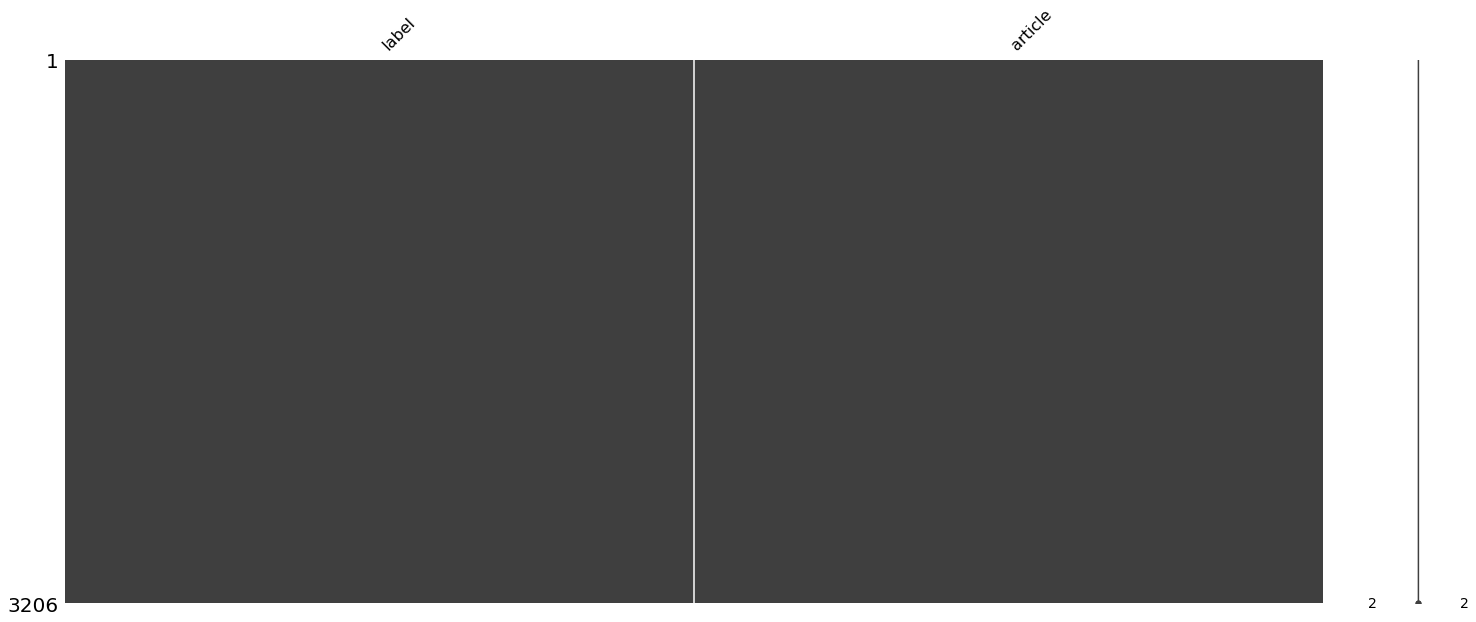

Missing: 0


In [11]:
missingno.matrix(df)
plt.show()
print("Missing: {}".format(df.isna().sum().sum()))

## Shuffling Dataset

In [13]:
from sklearn.utils import shuffle

df = shuffle(df).reset_index(drop=True)

In [14]:
df.head()

,label,article
0,0,Patunay sa pagtutok ng buong sambayanan ang pa...
1,1,Nagliyab sa galit si National Capital Region P...
2,0,"Ayon kay DoH spokesman Dr. Lyndon Lee Suy, dap..."
3,1,Nagpakawala na ang ating kasundaluhan ng mga a...
4,0,NAKASAMA kami sa pa-dinner ng negosyanteng si ...


In [15]:
df.tail()

,label,article
3201,0,"""Accused Juan Ponce Enrile, by counsel, respec..."
3202,1,Base sa ulat ng financial and media company na...
3203,1,"""Suntakan na lang, tanggalin mo ito (posas)."" ..."
3204,0,Kinumpirma noong Linggo ng gabi ni player-agen...
3205,0,"""Kung hindi mo kayang sukatin, hindi mo ito ka..."


In [28]:
df.loc[3201, 'article'] # 0

'"Accused Juan Ponce Enrile, by counsel, respectfully expresses his reservations over and objections to the Honorable Court\'s proposals made in open court on January 14, 2015 regarding (1) the termination of the preliminary conference in all the cases, and (2) the consolidation of all cases," pahayag ng mga abogado ni Enrile. Puntirya ng Sandiganbayan Third Division na mapabilis ang proseso ng paglilitis at hihilingin nito sa Korte Suprema na tapusin na ang preliminary conference na rito mamarkahan ang mga ebidensiya at magsasagawa ng joint trial sa mga kasong plunder at graft ni Enrile. Naglilitis ang Third Division sa isang kaso ng plunder at 15 bilang ng graft na inihain laban kay Enrile. "All told, while justice is intended to be administered with dispatch, this does not mean mere speed for speed\'s sake. The anxiety in concluding and disposing a case must not result in a deprivation of due process. The constitutional right of the accused to speedy trial is in place for his protec

In [29]:
df.loc[3202, 'article'] # 1

'Base sa ulat ng financial and media company na Bloomberg, naging Asia\'s best currency ang pera ng Pilipinas nitong Pebrero at maaring magtuloy-tuloy pa daw na malagpasan ng piso ang pera ng karatig bansa. Lalo din daw bubuti lagay ng pera ng Pilipinas sa tulong ng record remittances, rising investment at lumalagong domstic economy. "The peso has been stronger recently and could continue to outperform in the region, amid sustained net foreign portfolio investments on a widely expected further declining trend of local inflation," sabi ng ekonomista mula sa Rizal COmmercial Banking Corporation na si Mke Ricafort. Ayon pa sa impormasyong nakalap ng Bloomberg, tumataya umano ang mga namumuhunan sa peso matapos pumalo sa $763 million nitong Enero ang net inflow ng Philippine stock at bonds. Nakatulong din daw ang mga ipinadalang pera ng mga Overseas Filipino WOrkers sa kanilang pamilya sa Pilipinas. Lumakas din daw ang Piso laban sa Dolyar nitong Pebrero. "Investors are betting on the peso

# EDA

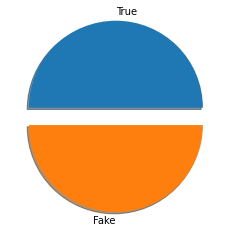

True news count:  1603
Fake news count:  1603


In [37]:
true_news = len(df[df['label'] == 1])
fake_news = len(df[df['label'] == 0])
plt.pie([true_news, fake_news], labels=['True', 'Fake'], explode = [0.2,0.0] , shadow=True)
plt.show()

print("True news count: ", true_news)
print("Fake news count: ", fake_news)